<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_top"><img src = "http://cocl.us/Pytorch_top" width = 950, align = "center"></a>

<img src = "https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width = 200, align = "center">

<h1 align=center><font size = 5>Using Dropout for Classification Assignment  </font></h1> 

# Table of Contents
in this lab, you will see how adding dropout to your model will decrease overfitting by using <code>nn.Sequential</code> and Cross Entropy Loss.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Make Some Data</a></li>
<li><a href="#ref1">Create the Model and Cost Function the Pytorch way</a></li>
<li><a href="#ref2">Batch Gradient Descent</a></li>
<br>
<p></p>
Estimated Time Needed: <strong>20 min</strong>
</div>

<hr>

Import all the libraries that you need for the lab:  

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap

Use this function only for plotting: 

In [2]:
def plot_decision_regions_3class(data_set,model=None):

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X=data_set.x.numpy()
    y=data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min()-0.1 , X[:, 0].max()+0.1 
    y_min, y_max = X[:, 1].min()-0.1 , X[:, 1].max() +0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    newdata=np.c_[xx.ravel(), yy.ravel()]
    
    #XX=torch.torch.Tensor(newdata)
    #_,yhat=torch.max(model(XX),1)
    #yhat=yhat.numpy().reshape(xx.shape)
    
    Z=data_set.fun(newdata).flatten()
    f=np.zeros(Z.shape)
    f[Z>0]=1
    f=f.reshape(xx.shape)
    if model!=None:
        model.eval()
        XX=torch.torch.Tensor(newdata)
        _,yhat=torch.max(model(XX),1)
        yhat=yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")
    plt.legend()
 

Use this function to calculate accuracy: 

In [3]:
def accuracy(model,data_set):
    _,yhat=torch.max(model(data_set.x),1)
    return (yhat==data_set.y).numpy().mean()

<a id="ref0"></a>
<h2 align=center>Get Some Data </h2>

Create a nonlinearly separable dataset:    

In [4]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self,N_SAMPLES = 1000,noise_std=0.1,train=True):
      
        a=np.matrix([-1,1,2,1,1,-3,1]).T
        
        self.x = np.matrix(np.random.rand(N_SAMPLES,2))

        self.f=np.array(a[0]+(self.x)*a[1:3]+np.multiply(self.x[:,0], self.x[:,1])*a[4]+np.multiply(self.x, self.x)*a[5:7]).flatten()
        self.a=a
       
        self.y=np.zeros(N_SAMPLES)
        self.y[self.f> 0]=1
        self.y=torch.from_numpy(self.y).type(torch.LongTensor)
        self.x=torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x+noise_std*torch.randn(self.x.size())
        self.f=torch.from_numpy(self.f)
        self.a=a
        if train==True:
            torch.manual_seed(1)
         
            self.x = self.x+noise_std*torch.randn(self.x.size())
            torch.manual_seed(0)
        
            
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len
    def plot(self):
        X=data_set.x.numpy()
        y=data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min() , X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        Z=data_set.fun(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f=np.zeros(Z.shape)
        f[Z>0]=1
        f=f.reshape(xx.shape)
        plt.title('True decision boundary  and sample points with noise ')
      

        plt.plot(self.x[self.y==0,0].numpy(),self.x[self.y==0,1].numpy(),'bo',label='y=0' ) 
        plt.plot(self.x[self.y==1,0].numpy(), self.x[self.y==1,1].numpy(),'ro',label='y=1' )
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    def fun(self,x):
        
        x=np.matrix(x)

        out=np.array(self.a[0]+(x)*self.a[1:3]+np.multiply(x[:,0], x[:,1])*self.a[4]+np.multiply(x, x)*self.a[5:7])
        out=np.array(out)
        return out
  

Create a dataset object:

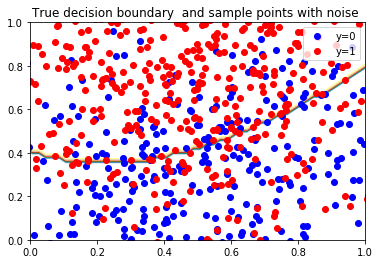

In [5]:
data_set=Data(noise_std=0.2)
data_set.plot()


Get some validation data: 

In [6]:
torch.manual_seed(0) 
validation_set=Data(train=False)

<a id="ref1"></a>
<h2 align=center>Create the Model, Optimizer, and Total Loss Function (cost)</h2>

### Create a three-layer neural network <code>model</code> with a ReLU() activation function for regression. All the appropriate layers should be 300 units.



Double-click __here__ for the solution.
<!-- Your answer is below:
    n_hidden = 300
    model= torch.nn.Sequential(
    torch.nn.Linear(2, n_hidden), 
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, 2)
)
  -->


### Create a three-layer neural network <code>model_drop</code> with a ReLU() activation function for regression. All the appropriate layers should be 300 units. Apply dropout to all but the last layer and make the probability of dropout is 50%.


Double-click __here__ for the solution.
<!-- Your answer is below:
n_hidden = 300
model_drop= torch.nn.Sequential(
    torch.nn.Linear(2, n_hidden),
    torch.nn.Dropout(0.5),  
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.Dropout(0.5), 
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, 2)
)
-->

<a id="ref2"></a>
<h2 align=center>Train the Model via Mini-Batch Gradient Descent </h2>

Set the model by using dropout to training mode; this is the default mode, but it's a good practice. 

In [ ]:
model_drop.train()

Train the model by using the Adam optimizer. See the unit on other optimizers. Use the Cross Entropy Loss:

In [ ]:
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

## Create the appropriate loss function.

<!-- Your answer is below:
criterion = torch.nn.CrossEntropyLoss()
-->


Initialize a dictionary that stores the training and validation loss for each model:

In [ ]:
LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

Run 500 iterations of batch gradient decent: 

In [ ]:
epochs=500

for epoch in range(epochs):
    #make a prediction for both models 
    yhat = model(data_set.x)
    yhat_drop = model_drop(data_set.x)
    #calculate the lossf or both models 
    loss = criterion(yhat, data_set.y)
    loss_drop = criterion(yhat_drop, data_set.y)
    
    #store the loss for  both the training and validation  data for both models 
    LOSS['training data no dropout'].append(loss.item())
    LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
    LOSS['training data dropout'].append(loss_drop.item())
    model_drop.eval()
    LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
    model_drop.train()
    
    #clear gradient 
    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    #Backward pass: compute gradient of the loss with respect to all the learnable parameters
    loss.backward()
    loss_drop.backward()
    #the step function on an Optimizer makes an update to its parameters
    optimizer_ofit.step()
    optimizer_drop.step()

Set the model with dropout to evaluation mode: 

In [ ]:
model_drop.eval()

### Test the accuracy of the model without dropout on the validation data. 

Double-click __here__ for the solution.
<!-- Your answer is below:
_,yhat=torch.max(model(validation_set.x),1)
(yhat==validation_set.y).numpy().mean()
-->

### Test the accuracy of the model without dropout on the validation data. 

Double-click __here__ for the solution.
<!-- Your answer is below:
_,yhat=torch.max(model_drop(validation_set.x),1)
(yhat==validation_set.y).numpy().mean()
-->


You see that the model with dropout performs better on the validation data. 

Plot the decision boundary and the prediction of the networks in different colors:

## true function

In [ ]:
plot_decision_regions_3class(data_set)

## model without dropout 

In [ ]:
plot_decision_regions_3class(data_set,model)

## model with dropout 

In [ ]:
plot_decision_regions_3class(data_set,model_drop)

You can see that the model using dropout does better at tracking the function that generated the data. 

Plot out the loss for training and validation data on both models:  

In [ ]:
plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)),label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

You see that the model without dropout performs better on the training data, but it performs worse on the validation data. This suggests overfitting.  However, the model using dropout performed better on the validation data, but worse on the training data. 

<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_bottom"><img src = "http://cocl.us/pytorch_image_bottom" width = 950, align = "center"></a>

### About the Authors:  

 [Joseph Santarcangelo]( https://www.linkedin.com/in/joseph-s-50398b136/) has a PhD in Electrical Engineering. His research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. 

Other contributors: [Michelle Carey](  https://www.linkedin.com/in/michelleccarey/), [Morvan Youtube channel]( https://www.youtube.com/channel/UCdyjiB5H8Pu7aDTNVXTTpcg), [Mavis Zhou](  https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/)

<hr>

Copyright &copy; 2018 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).